# Replicate the CERES model

## The CERES model

The following is the CERES model as desicrbed in ["Computational correction of copy number effect improves specificity of CRISPR–Cas9 essentiality screens in cancer cells"](https://www.nature.com/articles/ng.3984#Sec24) (Meyeres *et al*, 2017).


$
\quad D_{ij} = q_i \lgroup \sum_{k \in G_i} (h_k + g_{kj}) + \mathcal{f} (\sum_{l \in L_i} C_{lj}) \rgroup + o_i + \epsilon
$

where:

- $D_{ij}$: sgRNA $i$ depletion in cell line $j$
- $q_i$: "guide activity score... to mitigate the influence of low-quality reagents" (restricted $[0,1]$)
- $G_i$: the genes targeted by sgRNA $i$
- $h_k$: "shared" (non-cell-line-specific) effect of gene $k$
- $g_{kj}$: cell-line-specific effect in cell line $j$ and gene $k$
- $\mathcal{f}_j$: piecewise linear spine to model copy number effect
- $L_i$: target loci of sgRNA $i$
- $C_{lj}$: copy number of target locus $l$ in cell line $j$
- $o_i$: sgRNA-sepcific effect to account for noise in the measurement of sgRNA abundance in the reference pool
- $\epsilon$: normal error

### Notebook goal

Here I will build three models: (1) without a CN covariate, (2) with a standard linear covariate for copy number, and (3) with a spline function for the CNA covariate.
In this notebook, the models will be run with a subsample of the data, but they will eventually be turned into Python scripts to run on the full data set.

### Set-up

In [1]:
import string
import warnings
from pathlib import Path

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

### Data preparation

In [2]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)
data.head(n=7)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAGAGGCCGGTCAAATTCAG,42-mg-ba-311cas9_repa_p6_batch3,-0.405499,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.845287,1.328646,0,False,NaN,NaN,NaN,NaN,False,1.263034
1,AATCAACCCACAGCTGCACA,42-mg-ba-311cas9_repa_p6_batch3,-0.133541,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.827398,1.287359,2,False,missense_mutation;missense_mutation,FALSE;FALSE,TRUE;TRUE,TRUE;TRUE,False,5.220330
2,AATTACTACTTGCTTCCTGT,42-mg-ba-311cas9_repa_p6_batch3,-0.491495,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.879280,1.409165,0,False,NaN,NaN,NaN,NaN,False,3.008989
3,ACCTGTATGACGAAACCGTG,42-mg-ba-311cas9_repa_p6_batch3,-0.015850,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
4,ACTCTGTTCCTTCATCTCCG,42-mg-ba-311cas9_repa_p6_batch3,-0.530277,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.990378,1.692253,0,False,NaN,NaN,NaN,NaN,False,5.822730
5,ACTGCTGCGGGAATTCCAAG,42-mg-ba-311cas9_repa_p6_batch3,0.778827,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
6,AGACACTTATACTATGAAAG,42-mg-ba-311cas9_repa_p6_batch3,0.035950,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.872323,1.392463,0,False,NaN,NaN,NaN,NaN,False,3.701549


In [3]:
np.random.seed(RANDOM_SEED)
SAMPLED_GENES = data["hugo_symbol"].unique()
SAMPLED_CELL_LINES = np.random.choice(data["depmap_id"].unique(), 100)
data = data[data["hugo_symbol"].isin(SAMPLED_GENES)]
data = data[data["depmap_id"].isin(SAMPLED_CELL_LINES)]

In [4]:
print(f"testing with {data.shape[0]} data points")

testing with 19982 data points


In [5]:
def make_cat(df, col, ordered=True):
    """Make a column of a data frame into categorical."""
    df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=ordered)
    return df


cat_cols = [
    "sgrna",
    "replicate_id",
    "pdna_batch",
    "depmap_id",
    "lineage",
    "kras_mutation",
    "hugo_symbol",
    "chromosome",
]

for col in cat_cols:
    data = make_cat(data, col)

In [6]:
def count_unique(df, col):
    """Count the number of unique values in a column."""
    return len(df[col].unique())


def get_indices(df, col):
    """Get a list of the indices for a column."""
    return df[col].cat.codes.to_numpy()


num_sgrnas = count_unique(data, "sgrna")
num_genes = count_unique(data, "hugo_symbol")
num_cell_lines = count_unique(data, "depmap_id")

sgrna_idx = get_indices(data, "sgrna")
gene_idx = get_indices(data, "hugo_symbol")
cell_line_idx = get_indices(data, "depmap_id")

In [7]:
data["gene_cn_z"] = data["gene_cn"].apply(lambda x: np.min((x, 10)))
data["gene_cn_z"] = data.groupby("hugo_symbol")["gene_cn_z"].apply(
    lambda x: (x - np.mean(x)) / np.std(x)
)

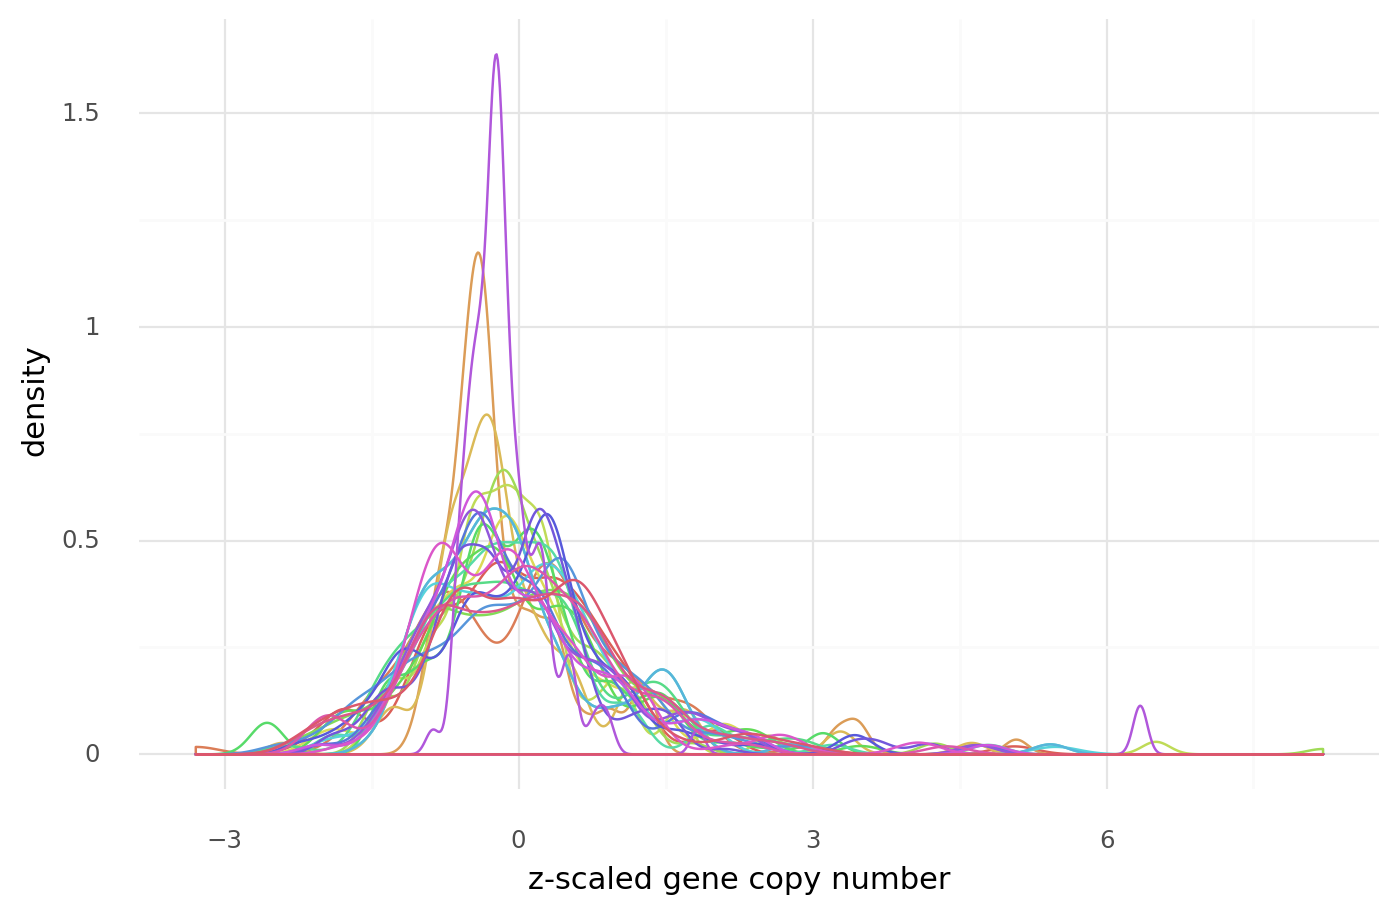

<ggplot: (8760942248653)>

In [8]:
(
    gg.ggplot(data, gg.aes(x="gene_cn_z"))
    + gg.geom_density(gg.aes(color="hugo_symbol"), size=0.5)
    + gg.scale_color_discrete(guide=False)
    + gg.theme(figure_size=(8, 5))
    + gg.labs(x="z-scaled gene copy number", y="density")
)

## Modeling

### Model 1.

Below is the model that will be fit with PyMC3 as the mimic of CERES without any covariate for the gene CN.

$
\quad D_{ij} \sim \mathcal{N}(\mu_{ij}, \epsilon) \\
\quad \mu_{ij} = q_i \lgroup h_k + g_{kj} \rgroup + o_i \\
\qquad q_i \sim \text{Beta}(2, 2) \\
\qquad h_k \sim \mathcal{N}(0, 1) \\
\qquad g_{kj} \sim \mathcal{N}(0, 1) \\
\qquad o_i \sim \mathcal{N}(0, 1) \\
\quad \epsilon \sim \text{Exp}(1)
$

In [9]:
with pm.Model() as ceres_m1:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx] * (h_k[gene_idx] + g_kj[gene_idx, cell_line_idx])
        + o_i[sgrna_idx],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=data.lfc)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


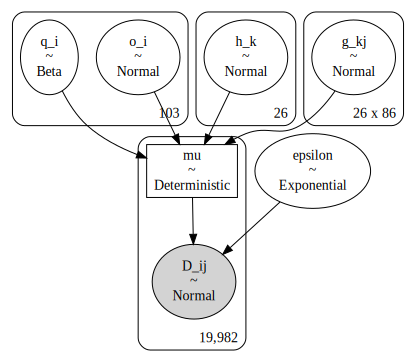

In [10]:
pm.model_to_graphviz(ceres_m1)

In [11]:
%%time

ceres_m1_cachedir = pymc3_cache_dir / "ceres_m1"

ceres_m1_samples = pmhelp.pymc3_sampling_procedure(
    model=ceres_m1,
    num_mcmc=3000,
    tune=1500,
    chains=3,
    cores=4,
    prior_check_samples=1000,
    ppc_samples=2000,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m1_cachedir,
    force=False,
)

Loading cached trace and posterior sample...


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


CPU times: user 6.09 s, sys: 1.25 s, total: 7.34 s
Wall time: 8.29 s


In [12]:
az_ceres_m1 = az.from_pymc3(
    trace=ceres_m1_samples["trace"],
    model=ceres_m1,
    prior=ceres_m1_samples["prior_predictive"],
    posterior_predictive=ceres_m1_samples["posterior_predictive"],
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


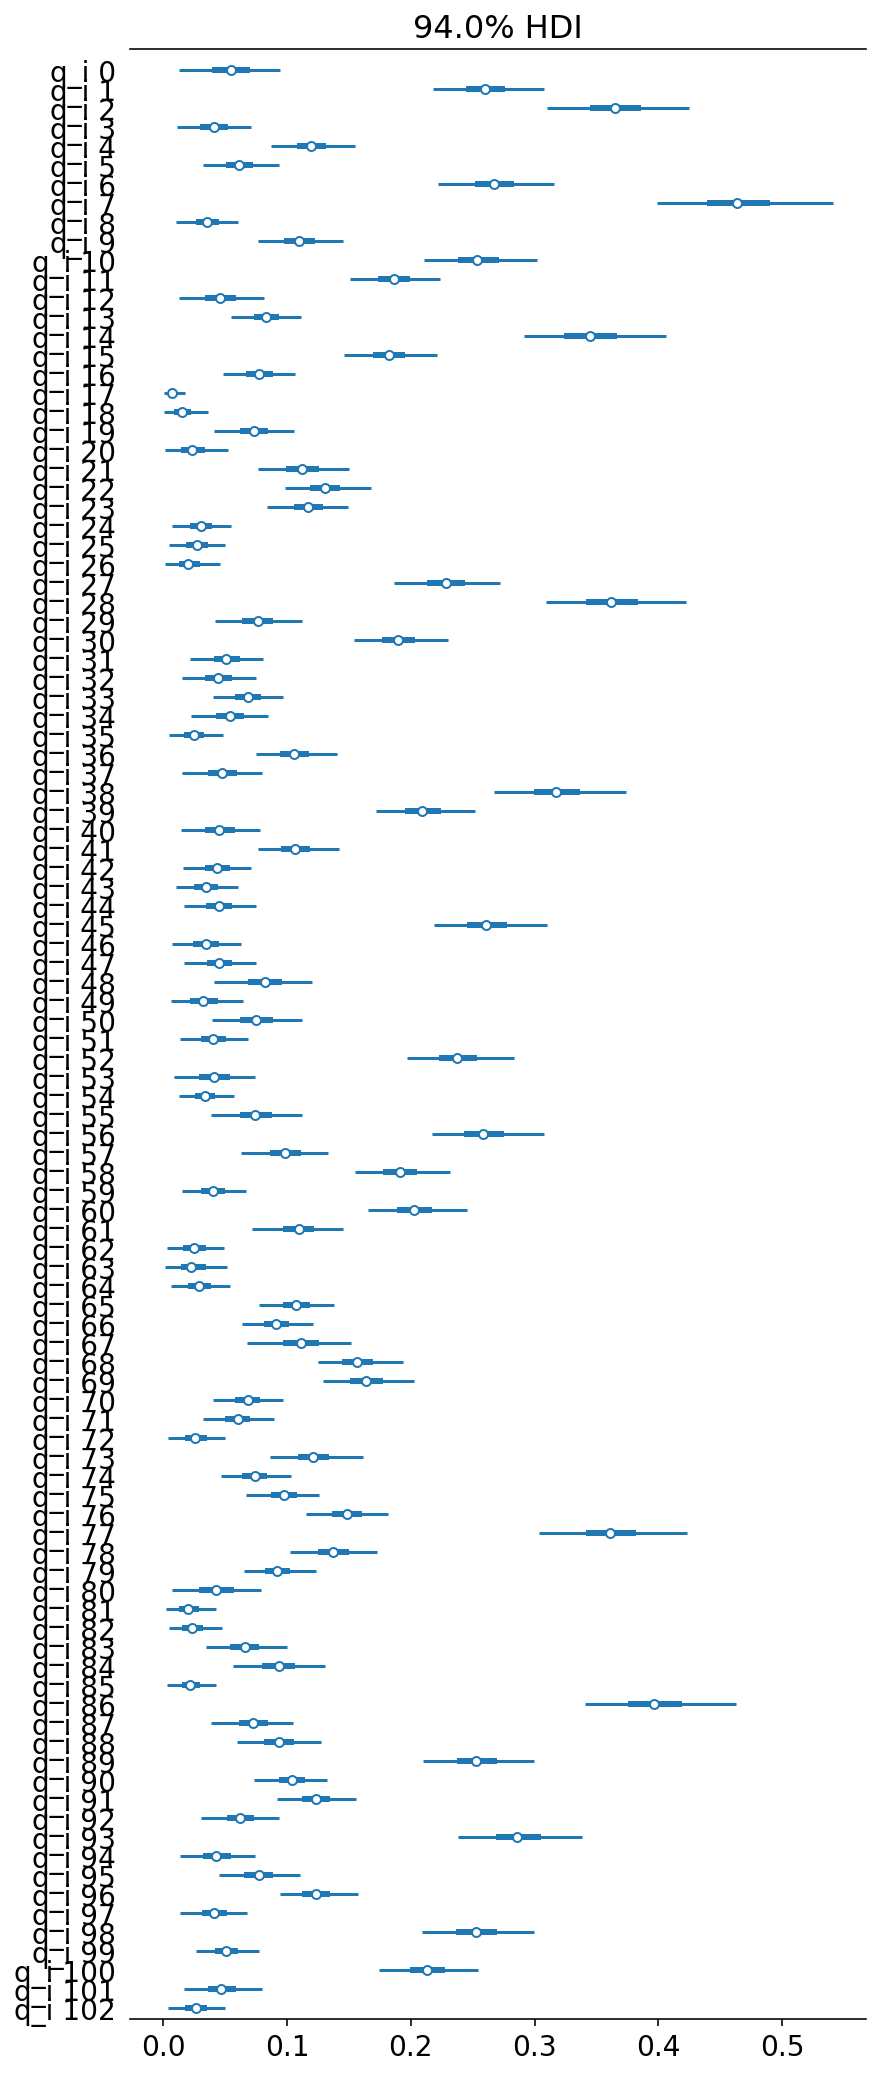

In [13]:
az.plot_forest(az_ceres_m1, var_names="q_i", combined=True)
plt.show()

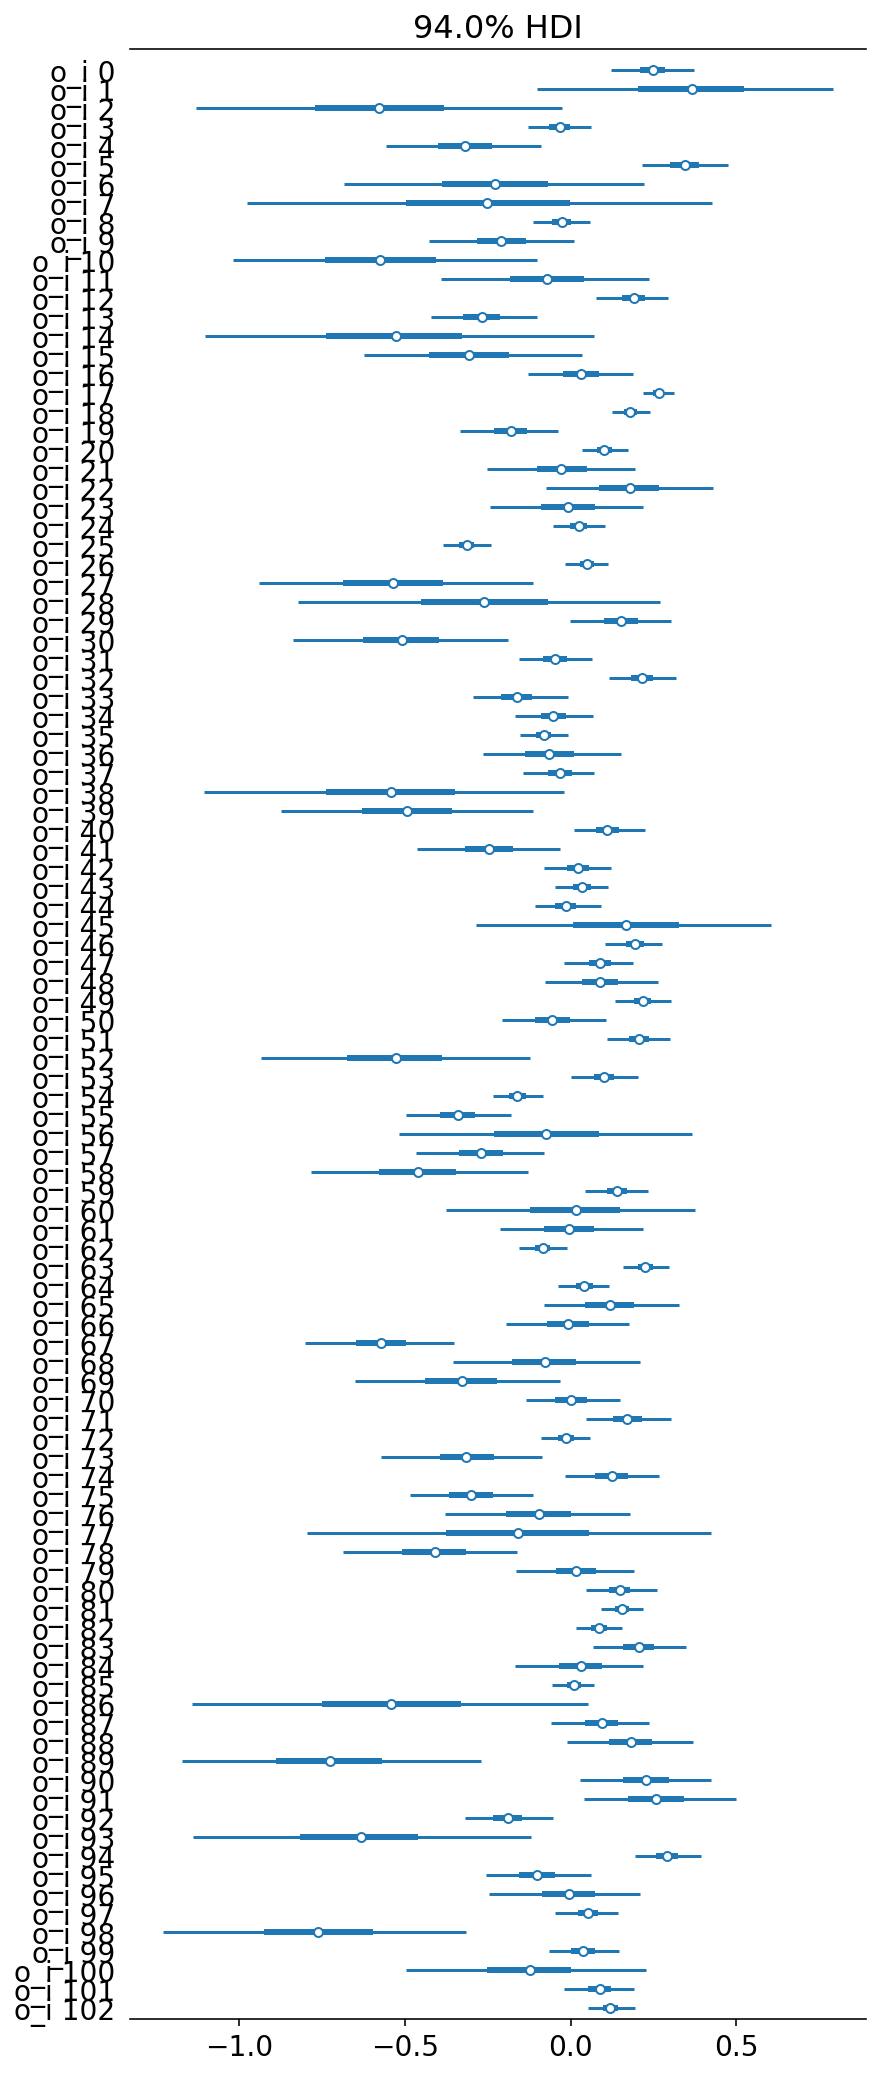

In [14]:
az.plot_forest(az_ceres_m1, var_names="o_i", combined=True)
plt.show()

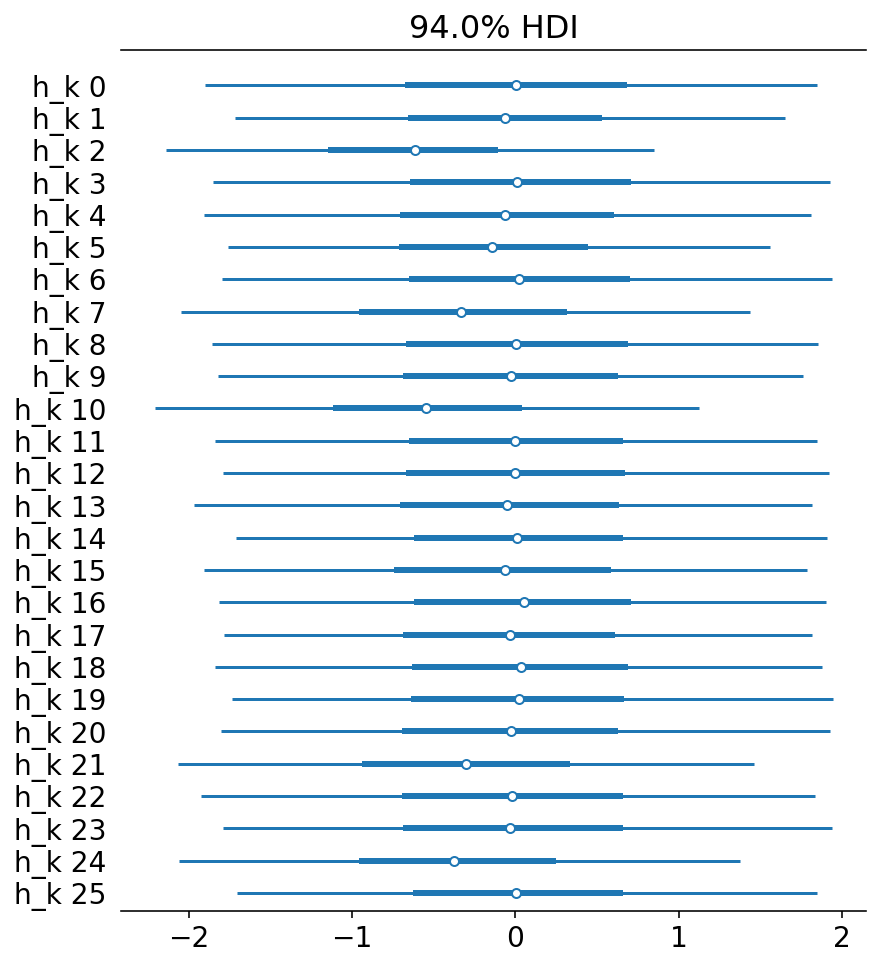

In [15]:
az.plot_forest(az_ceres_m1, var_names="h_k", combined=True)
plt.show()

In [16]:
gene_effect_post = ceres_m1_samples["trace"].get_values("g_kj")
gene_effect_post.shape

(9000, 26, 86)

In [17]:
gene_effect_mean = gene_effect_post.mean(axis=0)
gene_effect_mean.shape

(26, 86)

In [18]:
gene_effect_post_df = (
    pd.DataFrame(gene_effect_mean)
    .reset_index()
    .rename(columns={"index": "gene_idx"})
    .melt(id_vars="gene_idx", var_name="cell_line_idx", value_name="gene_effect")
    .assign(
        hugo_symbol=lambda d: [
            data["hugo_symbol"].values.categories[i] for i in d["gene_idx"].values
        ],
        depmap_id=lambda d: [
            data["depmap_id"].values.categories[i] for i in d["cell_line_idx"].values
        ],
    )
)

cols = ["depmap_id", "kras_mutation", "is_deleterious"]
mutation_info = data[cols].drop_duplicates()
mutation_info[cols[:-1]] = mutation_info[cols[:-1]].astype("str")

gene_effect_post_df = gene_effect_post_df.merge(
    mutation_info, how="left", on=["depmap_id"]
)

gene_effect_post_df.head(n=7)

,gene_idx,cell_line_idx,gene_effect,hugo_symbol,depmap_id,kras_mutation,is_deleterious
0,0,0,1.189885,PDE5A,ACH-000757,G12D,NaN
1,0,0,1.189885,PDE5A,ACH-000757,G12D,FALSE
2,1,0,0.933719,TP53,ACH-000757,G12D,NaN
3,1,0,0.933719,TP53,ACH-000757,G12D,FALSE
4,2,0,-1.244338,KRAS,ACH-000757,G12D,NaN
5,2,0,-1.244338,KRAS,ACH-000757,G12D,FALSE
6,3,0,0.993389,KIF3C,ACH-000757,G12D,NaN


In [19]:
data.is_deleterious.unique()

array([nan, 'FALSE', 'TRUE', 'FALSE;TRUE', 'FALSE;FALSE;FALSE',
       'TRUE;TRUE;FALSE', 'FALSE;FALSE', 'FALSE;FALSE;TRUE;FALSE;TRUE',
       'TRUE;TRUE', 'FALSE;TRUE;TRUE', 'FALSE;TRUE;FALSE', 'TRUE;FALSE'],
      dtype=object)

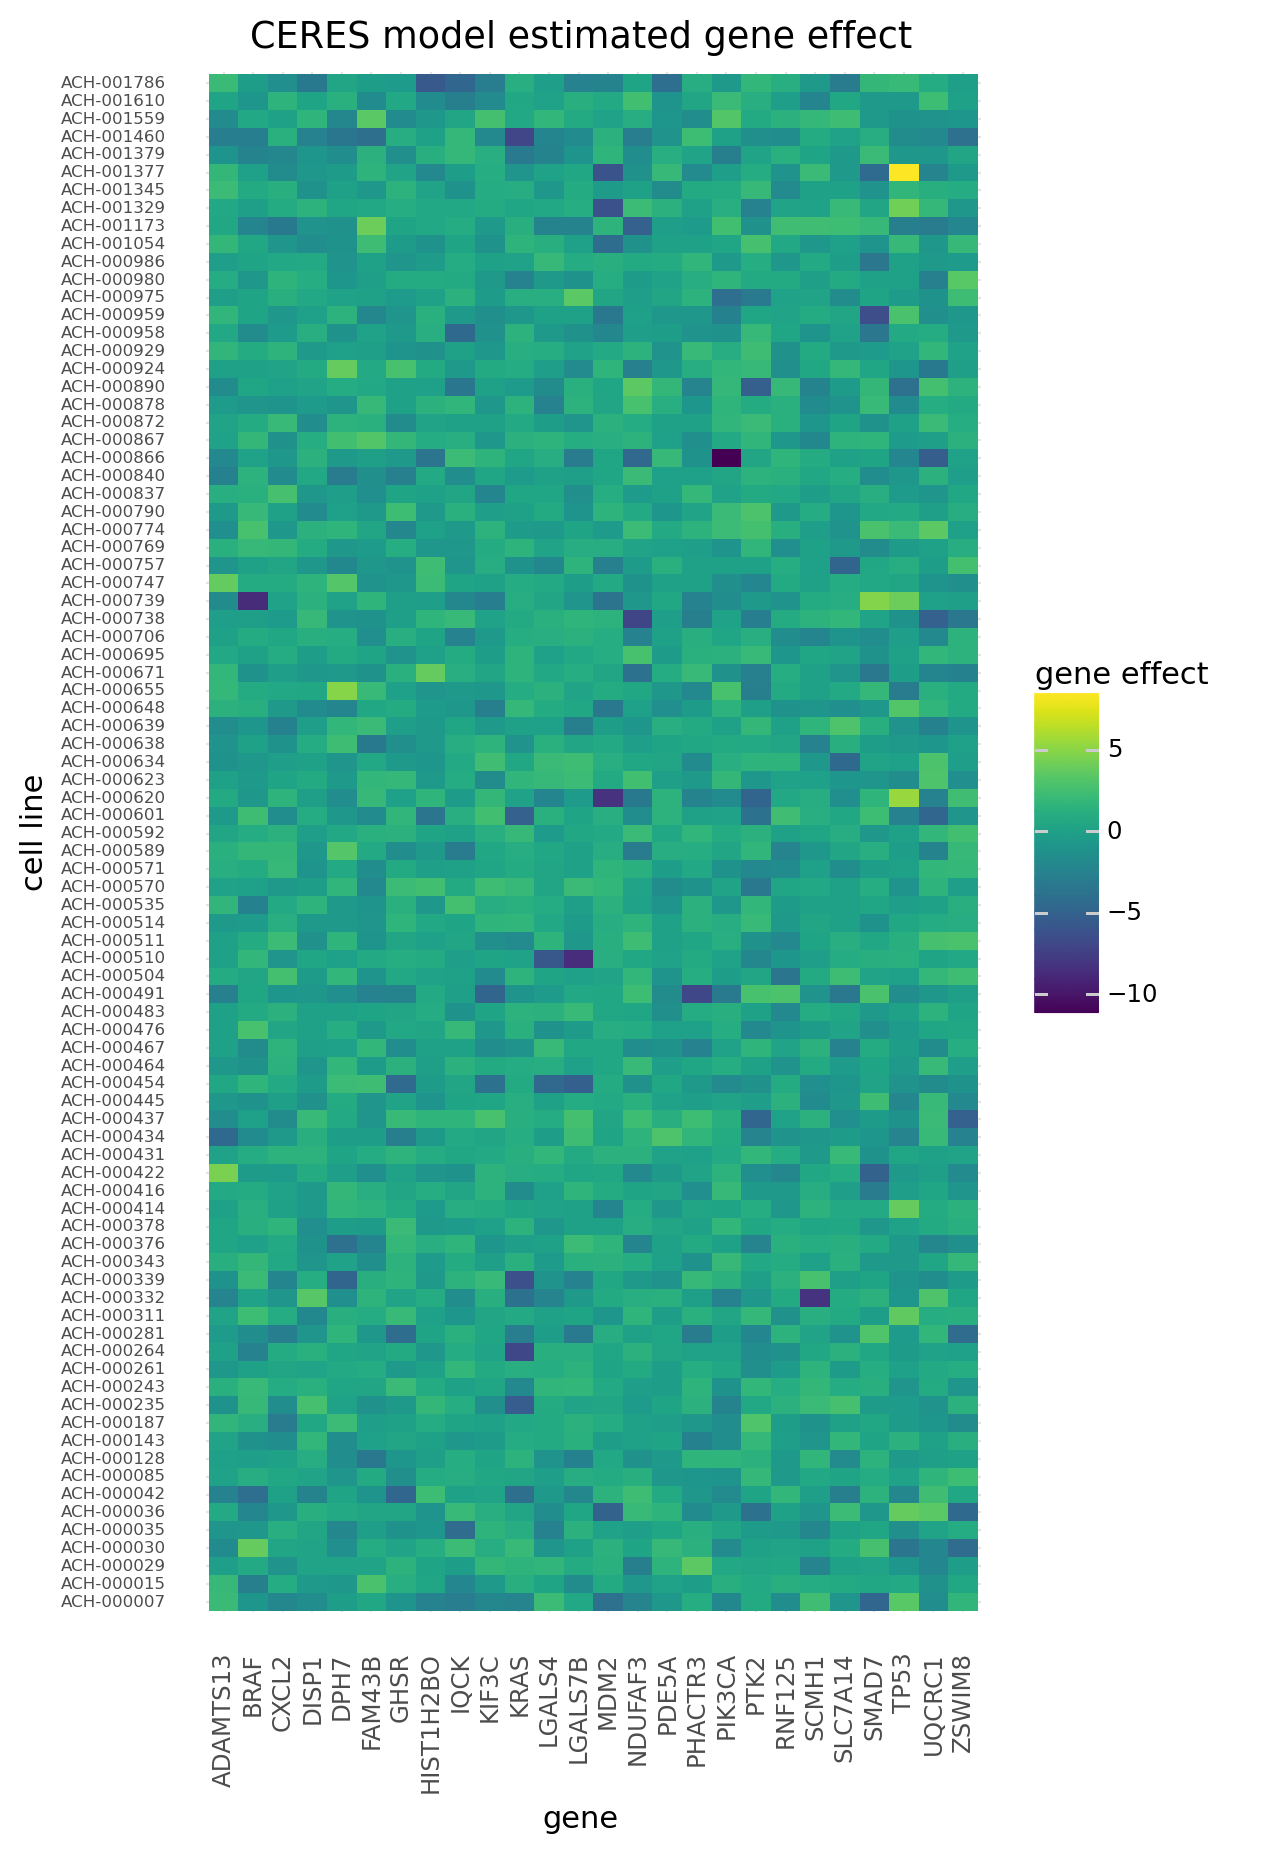

<ggplot: (8760909532950)>

In [20]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_tile(gg.aes(fill="gene_effect"))
    + gg.theme(
        figure_size=(5, 10),
        axis_text_x=gg.element_text(angle=90),
        axis_text_y=gg.element_text(size=6),
    )
    + gg.labs(
        x="gene",
        y="cell line",
        fill="gene effect",
        title="CERES model estimated gene effect",
    )
)

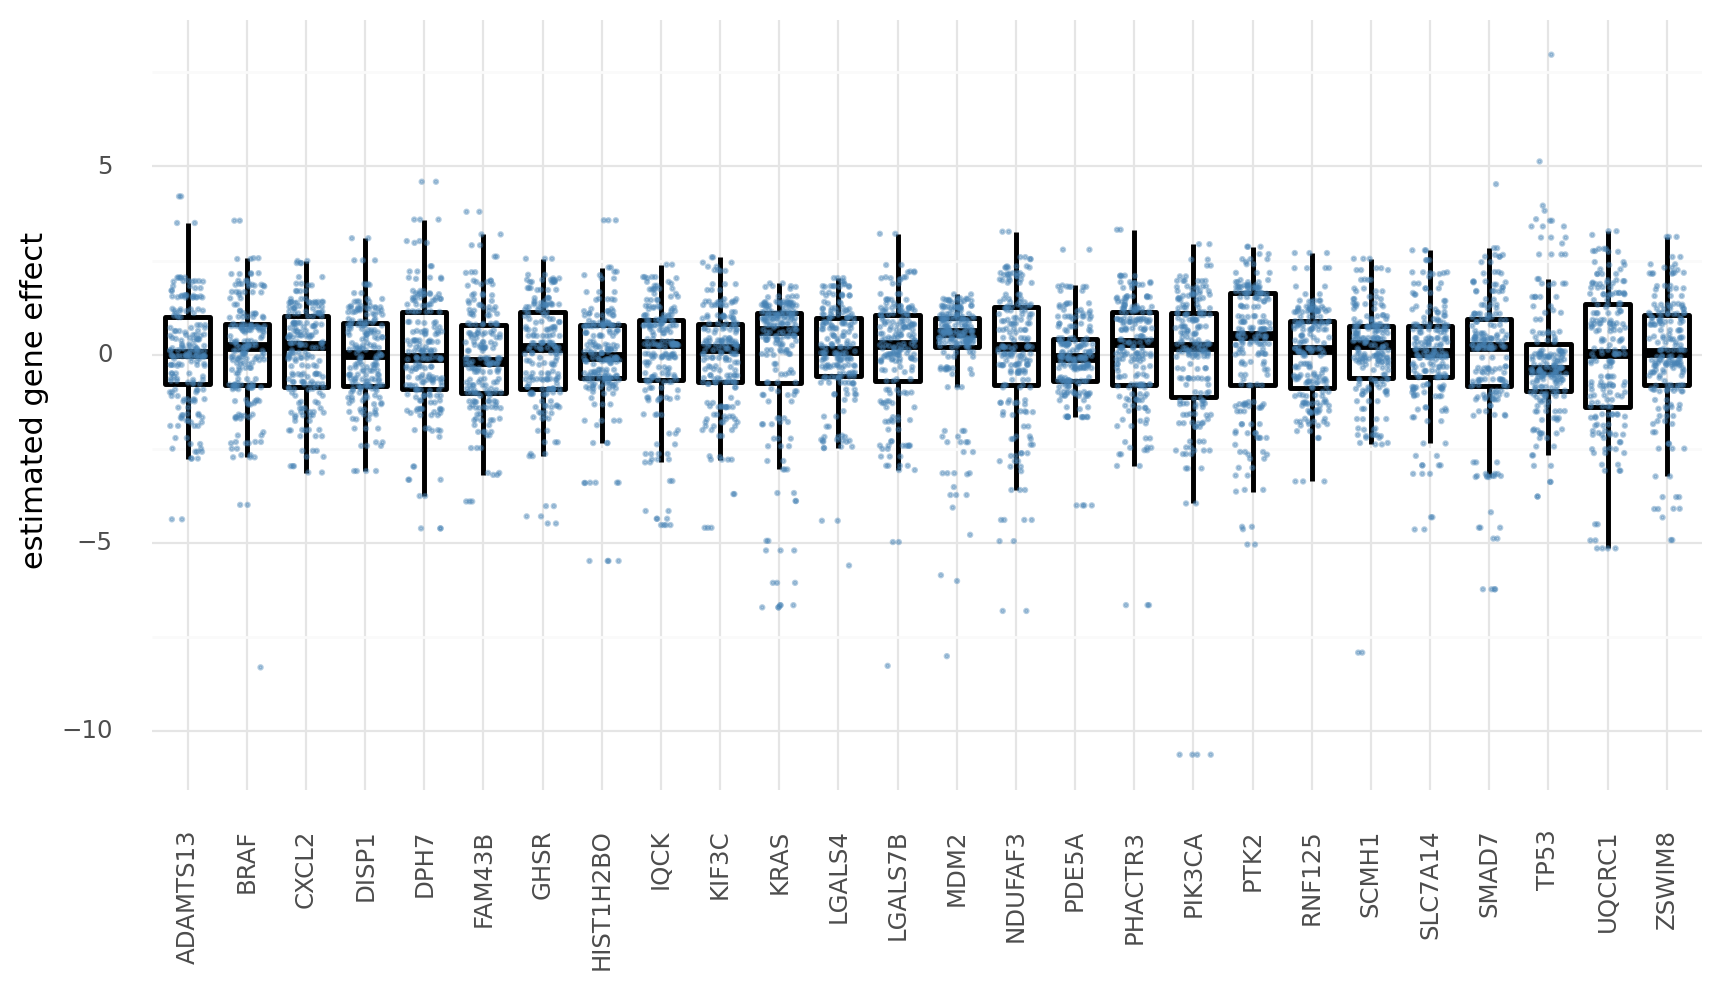

<ggplot: (8760909561296)>

In [21]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="hugo_symbol", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="black", outlier_alpha=0, size=1)
    + gg.geom_jitter(alpha=0.4, size=0.3, height=0, width=0.3, color="steelblue")
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(10, 5)
    )
    + gg.labs(x=None, y="estimated gene effect")
)

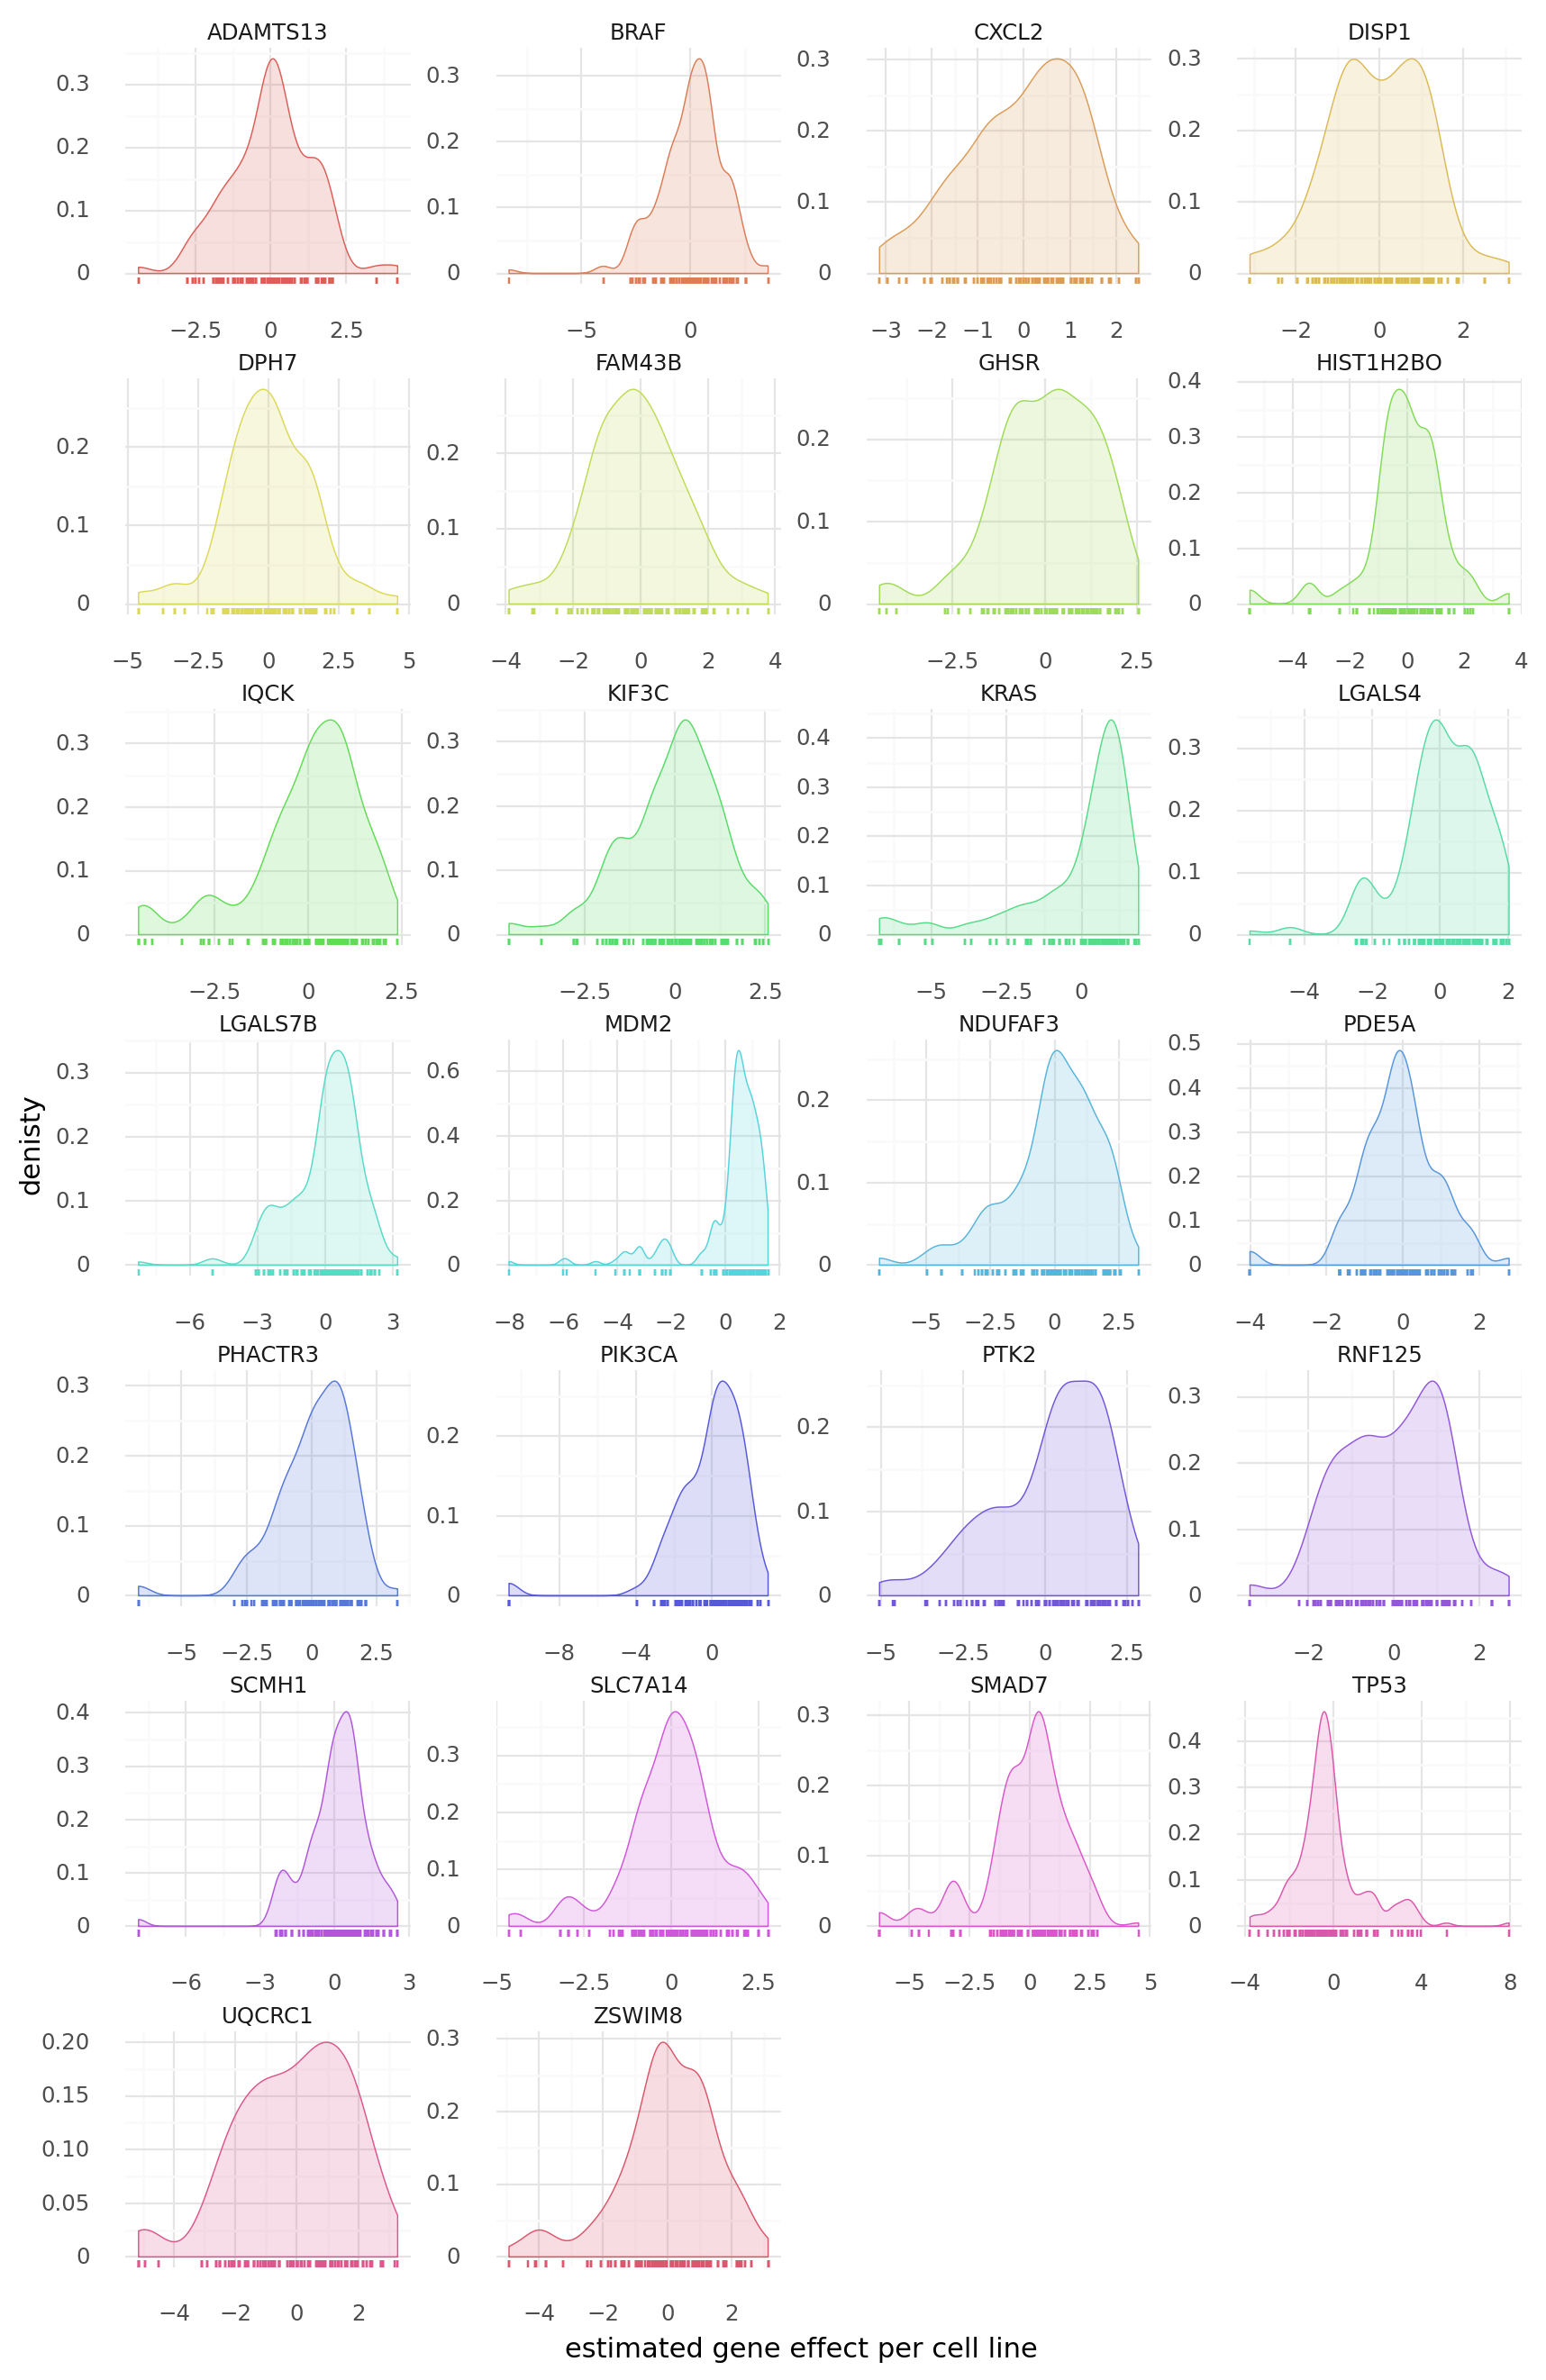

<ggplot: (8760666590838)>

In [22]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="gene_effect"))
    + gg.facet_wrap("hugo_symbol", ncol=4, scales="free")
    + gg.geom_density(
        gg.aes(color="hugo_symbol", fill="hugo_symbol"), alpha=0.2, size=0.3
    )
    + gg.geom_rug(gg.aes(color="hugo_symbol"))
    + gg.theme(
        figure_size=(10, 16),
        legend_position="none",
        subplots_adjust={"hspace": 0.4, "wspace": 0.3},
    )
    + gg.labs(x="estimated gene effect per cell line", y="denisty")
)

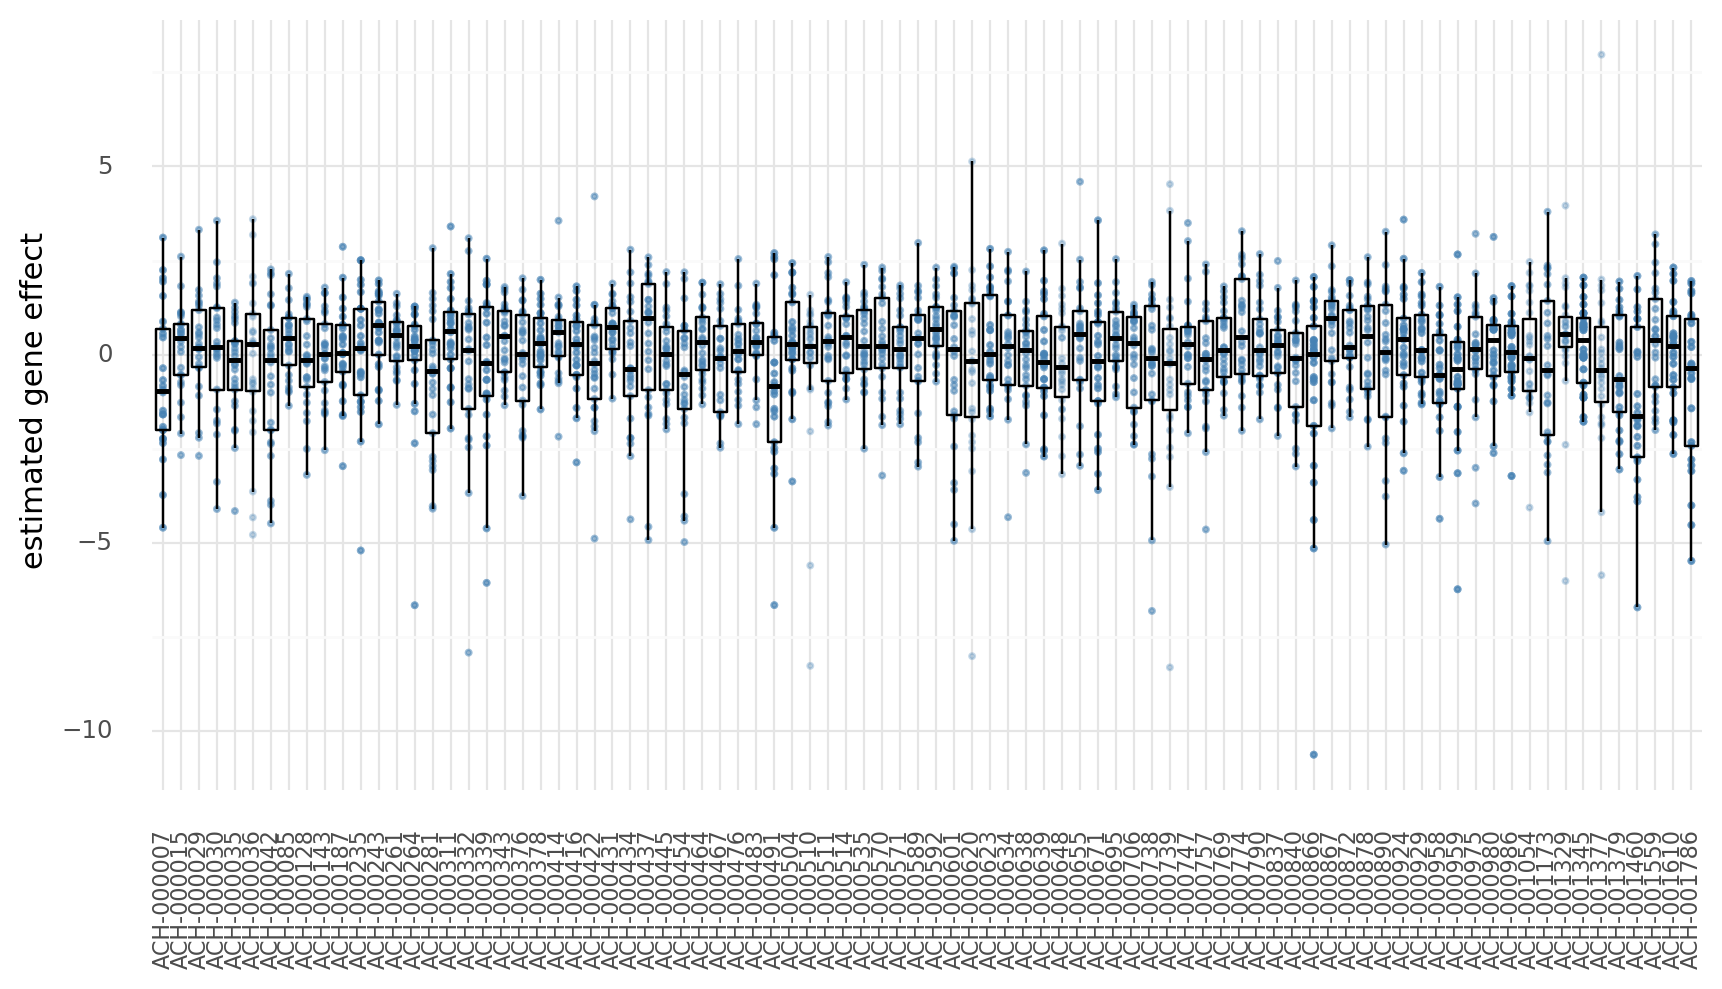

<ggplot: (8760666701927)>

In [23]:
(
    gg.ggplot(gene_effect_post_df, gg.aes(x="depmap_id", y="gene_effect"))
    + gg.geom_jitter(alpha=0.3, size=0.6, height=0, width=0, color="steelblue")
    + gg.geom_boxplot(alpha=0, color="black", outlier_alpha=0)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1, size=8),
        figure_size=(10, 5),
    )
    + gg.labs(x=None, y="estimated gene effect")
)

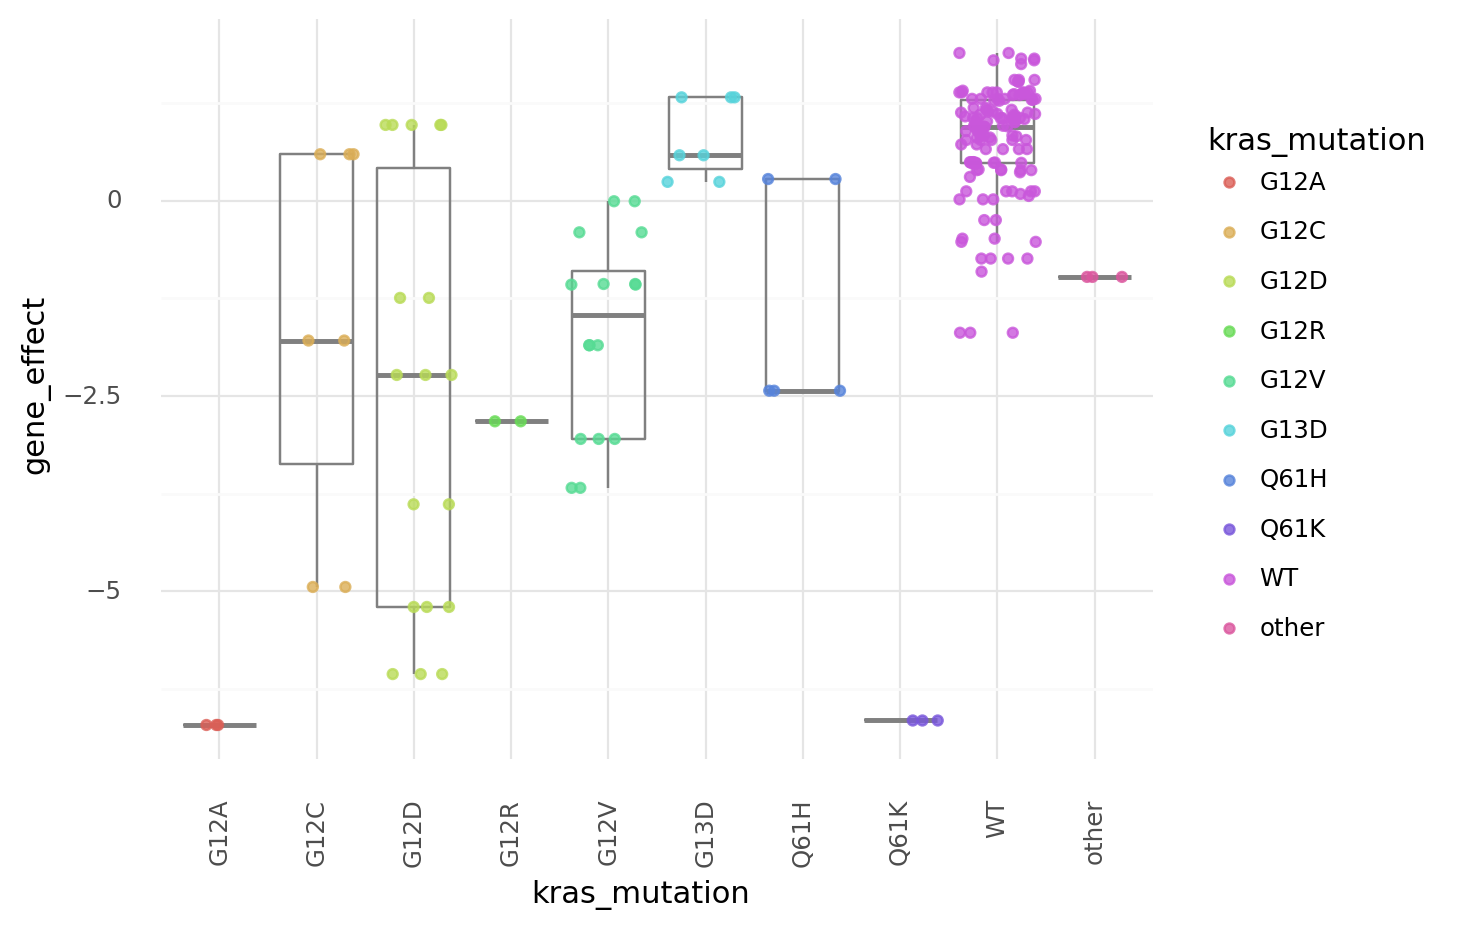

<ggplot: (8760909018447)>

In [24]:
kras_gene_effect = gene_effect_post_df[
    gene_effect_post_df.hugo_symbol == "KRAS"
].reset_index(drop=True)

(
    gg.ggplot(kras_gene_effect, gg.aes(x="kras_mutation", y="gene_effect"))
    + gg.geom_boxplot(alpha=0, color="gray", outlier_alpha=0)
    + gg.geom_jitter(gg.aes(color="kras_mutation"), width=0.4, height=0, alpha=0.8)
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1))
)

---

### Model 2.

Below is the model that will be fit with PyMC3 as the mimic of CERES with a covariate for the gene CN modeled as a standard linear coefficient.
The copy number values were z-scaled within each gene.

$
\quad D_{ij} \sim \mathcal{N}(\mu_{ij}, \epsilon) \\
\quad \mu_{ij} = q_i \lgroup h_k + g_{kj} + \beta_{ij} C \rgroup + o_i \\
\qquad q_i \sim \text{Beta}(2, 2) \\
\qquad h_k \sim \mathcal{N}(0, 1) \\
\qquad g_{kj} \sim \mathcal{N}(0, 1) \\
\qquad o_i \sim \mathcal{N}(0, 1) \\
\quad \epsilon \sim \text{Exp}(1)
$

In [37]:
BATCH_SIZE = 100
sgrna_idx_mb = pm.Minibatch(sgrna_idx, batch_size=BATCH_SIZE)
gene_idx_mb = pm.Minibatch(gene_idx, batch_size=BATCH_SIZE)
cell_line_idx_mb = pm.Minibatch(cell_line_idx, batch_size=BATCH_SIZE)

gene_cn_z_mb = pm.Minibatch(data.gene_cn_z.to_numpy(), batch_size=BATCH_SIZE)
lfc_mb = pm.Minibatch(data.lfc.to_numpy(), batch_size=BATCH_SIZE)

with pm.Model() as ceres_m2:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    beta_ij = pm.Normal("beta_ij", -0.5, 1, shape=(num_sgrnas, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx_mb]
        * (
            h_k[gene_idx_mb]
            + g_kj[gene_idx_mb, cell_line_idx_mb]
            + beta_ij[sgrna_idx_mb, cell_line_idx_mb] * gene_cn_z_mb
        )
        + o_i[sgrna_idx_mb],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=lfc_mb, total_size=len(data))

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


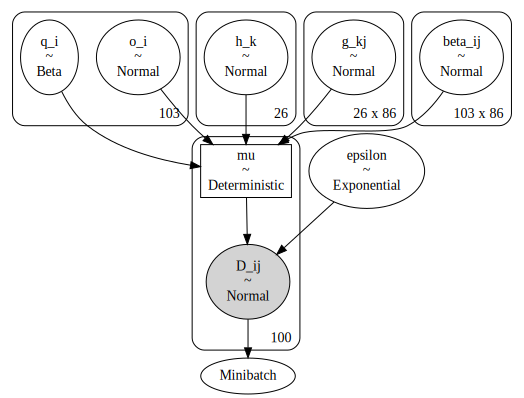

In [38]:
pm.model_to_graphviz(ceres_m2)

In [39]:
%%time

with ceres_m2:
    ceres_m2_advi_meanfield = pm.fit(
        40000,
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)],
        random_seed=RANDOM_SEED,
    )

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Finished [100%]: Average Loss = 92.575


CPU times: user 2min 5s, sys: 1.86 s, total: 2min 7s
Wall time: 2min 7s


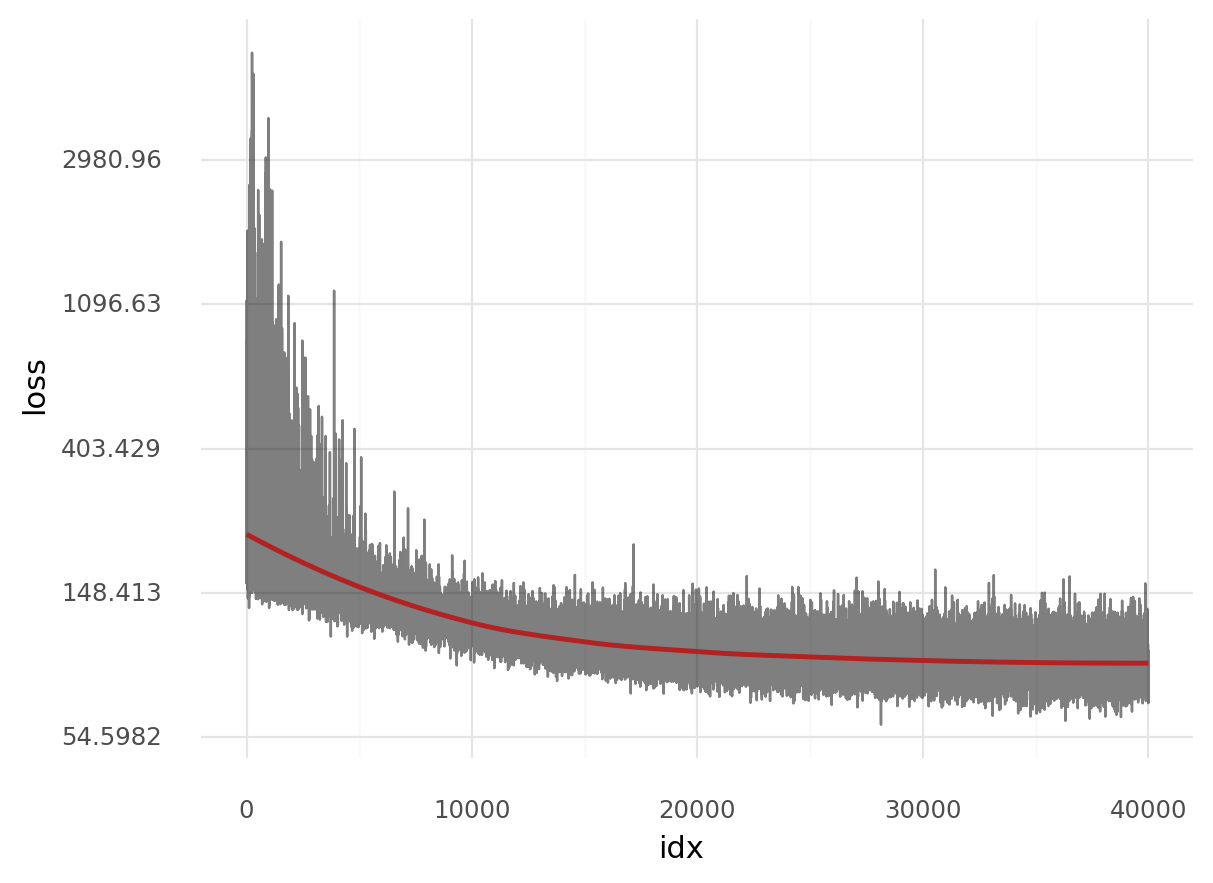

<ggplot: (8760653738277)>

In [40]:
df = pd.DataFrame(
    {
        "loss": ceres_m2_advi_meanfield.hist,
        "idx": range(len(ceres_m2_advi_meanfield.hist)),
    }
)
(
    gg.ggplot(df, gg.aes(x="idx", y="loss"))
    + gg.geom_line(group="a", color="black", alpha=0.5)
    + gg.geom_smooth(method="loess", se=False, color="firebrick")
    + gg.scale_y_continuous(trans="log")
)

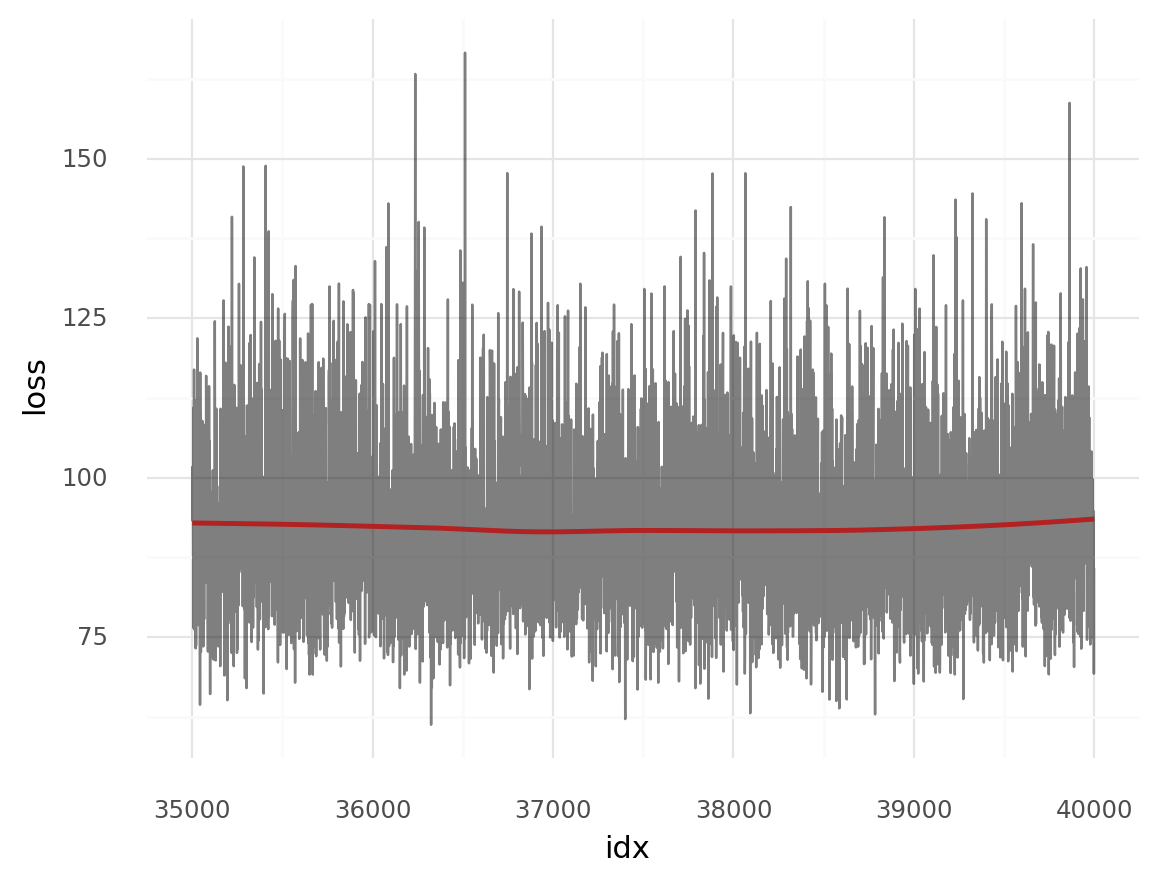

<ggplot: (8760654245852)>

In [41]:
(
    gg.ggplot(df.tail(n=5000), gg.aes(x="idx", y="loss"))
    + gg.geom_line(group="a", color="black", alpha=0.5)
    + gg.geom_smooth(method="loess", se=False, color="firebrick")
)

In [27]:
with pm.Model() as ceres_m2_full:
    # Priors
    q_i = pm.Beta("q_i", alpha=2, beta=2, shape=num_sgrnas)
    h_k = pm.Normal("h_k", 0, 1, shape=num_genes)
    g_kj = pm.Normal("g_kj", 0, 2, shape=(num_genes, num_cell_lines))
    beta_ij = pm.Normal("beta_ij", -0.5, 1, shape=(num_sgrnas, num_cell_lines))
    o_i = pm.Normal("o_i", 0, 1, shape=num_sgrnas)

    # Model
    mu_ij = pm.Deterministic(
        "mu",
        q_i[sgrna_idx]
        * (
            h_k[gene_idx]
            + g_kj[gene_idx, cell_line_idx]
            + beta_ij[sgrna_idx, cell_line_idx] * data.gene_cn_z.values
        )
        + o_i[sgrna_idx],
    )
    epsilon = pm.Exponential("epsilon", 1)

    # Likelihood
    D_ij = pm.Normal("D_ij", mu_ij, epsilon, observed=data.lfc.values)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [31]:
%%time

ceres_m2_mcmc_cachedir = pymc3_cache_dir / "ceres_m2_mcmc"

ceres_m2_mcmc_res = pmhelp.pymc3_sampling_procedure(
    model=ceres_m2_full,
    num_mcmc=2000,
    tune=2000,
    chains=2,
    cores=1,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m2_mcmc_cachedir,
    sample_kwags={},  # REMOVE THIS ARG NEXT TIME (FIXED)
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, o_i, beta_ij, g_kj, h_k, q_i]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 3066 seconds.
The number of effective samples is smaller than 10% for some parameters.


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Caching trace and posterior sample...
CPU times: user 4h 32min 28s, sys: 35min 22s, total: 5h 7min 51s
Wall time: 52min 42s


In [33]:
az_ceres_m2 = az.from_pymc3(
    trace=ceres_m2_mcmc_res["trace"],
    model=ceres_m2_full,
    posterior_predictive=ceres_m2_mcmc_res["posterior_predictive"],
    prior=ceres_m2_mcmc_res["prior_predictive"],
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [28]:
%%time

ceres_m2_mcmc_advi_cachedir = pymc3_cache_dir / "ceres_m2_mcmc_advi"

ceres_m2_mcmc_advi_res = pmhelp.pymc3_sampling_procedure(
    model=ceres_m2_full,
    num_mcmc=2000,
    tune=2000,
    chains=2,
    cores=1,
    random_seed=RANDOM_SEED,
    cache_dir=ceres_m2_mcmc_advi_cachedir,
    sample_kwags={"init": "advi", "n_init": 40000},
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Finished [100%]: Average Loss = 8,389.8
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In th

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 1183 seconds.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Caching trace and posterior sample...
CPU times: user 1h 50min 32s, sys: 13min 47s, total: 2h 4min 19s
Wall time: 26min 6s


In [58]:
az_ceres_m2_advi = az.from_pymc3(
    trace=ceres_m2_mcmc_advi_res["trace"],
    model=ceres_m2_full,
    posterior_predictive=ceres_m2_mcmc_advi_res["posterior_predictive"],
    prior=ceres_m2_mcmc_advi_res["prior_predictive"],
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
arviz.data.io_pymc3 - WARNING - posterior predictive variable D_ij's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


### Compare ADVI, MCMC, ADVI + MCMC

In [68]:
# Sample from posterior of ADVI fit.
np.random.seed(RANDOM_SEED)
ceres_m2_advi_sample = ceres_m2_advi_meanfield.sample(1000)


def mod_az_summary(df, trace_lbl):
    colname_changes = {
        "index": "variable",
        "hdi_5.5%": "hdi_lower",
        "hdi_94.5%": "hdi_upper",
    }
    keep_cols = ["trace", "variable", "mean", "hdi_lower", "hdi_upper"]
    mod_df = (
        df.reset_index(drop=False)
        .rename(columns=colname_changes)
        .assign(trace=trace_lbl)[keep_cols]
    )
    return mod_df


def mod_advi_summary(df, trace_lbl="ADVI"):
    return df.assign(trace=trace_lbl)


def summarise_advi_sample(ary, axis=0, hdi_prob=0.89):
    means = ary.mean(axis=axis)
    hdi = az.hdi(ary, hdi_prob=hdi_prob)
    return pd.DataFrame({"mean": means, "hdi_lower": hdi[:, 0], "hdi_upper": hdi[:, 1]})


def get_merged_posterior(var_name):
    mcmc_post = az.summary(az_ceres_m2, var_names=var_name, hdi_prob=0.89)
    mcmc_advi_post = az.summary(az_ceres_m2_advi, var_names=var_name, hdi_prob=0.89)
    advi_post = summarise_advi_sample(ceres_m2_advi_sample[var_name])
    advi_post["variable"] = mcmc_post.index.values

    merged_post = pd.concat(
        [
            mod_az_summary(mcmc_post, "MCMC"),
            mod_az_summary(mcmc_advi_post, "ADVI + MCMC"),
            mod_advi_summary(advi_post),
        ]
    ).reset_index(drop=True)
    merged_post["variable"] = pd.Categorical(
        merged_post["variable"],
        categories=mcmc_post.index.values,
        ordered=True,
    )

    return merged_post

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [69]:
merged_qi_posterior = get_merged_posterior("q_i")
merged_qi_posterior.head()

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,trace,variable,mean,hdi_lower,hdi_upper
0,MCMC,q_i[0],0.052,0.022,0.083
1,MCMC,q_i[1],0.213,0.185,0.238
2,MCMC,q_i[2],0.308,0.276,0.346
3,MCMC,q_i[3],0.038,0.015,0.060
4,MCMC,q_i[4],0.108,0.081,0.132


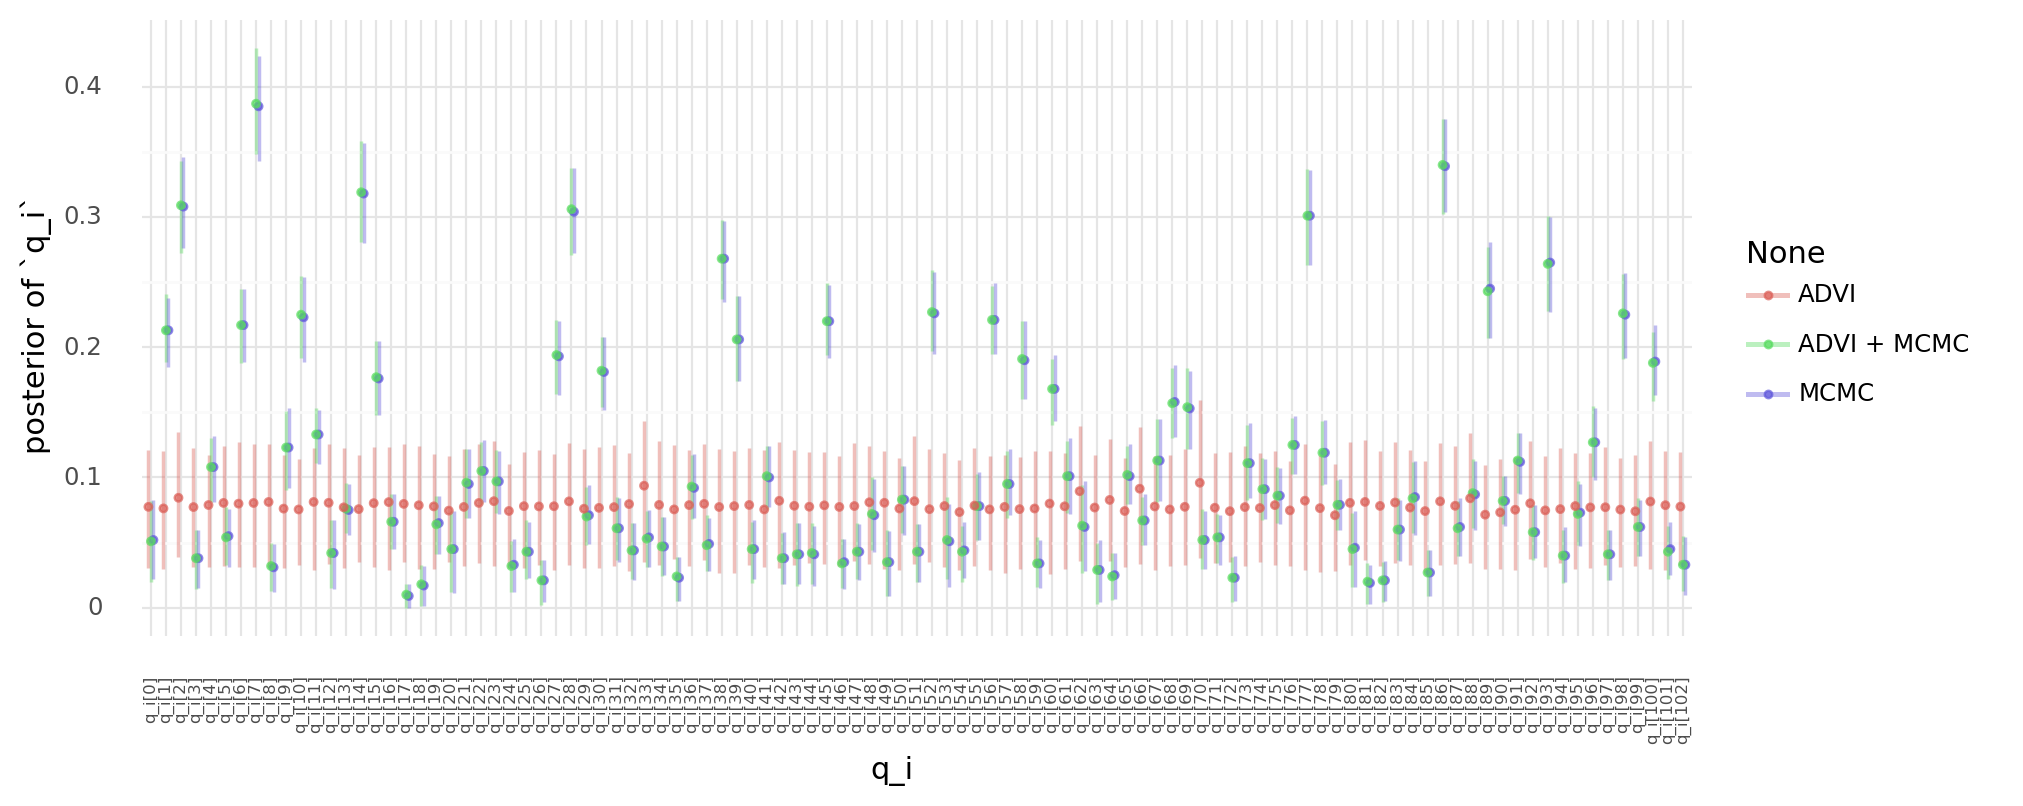

<ggplot: (8760647170588)>

In [70]:
pos = gg.position_dodge(width=0.5)

(
    gg.ggplot(merged_qi_posterior, gg.aes(x="variable"))
    + gg.geom_linerange(
        gg.aes(ymin="hdi_lower", ymax="hdi_upper", color="trace"),
        position=pos,
        size=0.7,
        alpha=0.4,
    )
    + gg.geom_point(gg.aes(y="mean", color="trace"), position=pos, size=1, alpha=0.7)
    + gg.theme(
        figure_size=(10, 4),
        axis_text_x=gg.element_text(size=6, angle=90, hjust=0.5, vjust=1),
        legend_position="right",
    )
    + gg.labs(x="q_i", y="posterior of `q_i`", color=None)
)

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m